### Preparing the Enviroment

In [22]:
# Install all necessary libraries in case they don't already exist in our enviroment
!pip3 install kaggle
!pip3 install lightgbm
!pip3 install psycopg2==2.7.6
!pip3 install mlflow

# Update Linux Sources in case we need to Install stuff
!apt-get update
!apt-get install unzip
!apt-get install libgomp1 # Fix por LightGBM

## Be ready to parse Kaggle Competition Results later on

def parse_kaggle_submissions(submits):
    '''
    After having captured results from -> !kaggle competitions submissions
    into a variable named "submits" parse them and return them as a DataFrame
    '''
    headers = list(filter(None, submits[0].split(" ")))
    data = pd.DataFrame(columns=headers)
    for x in submits[2:]:
        #parse items by order
        items = list(filter(None, x.split(" ")))
        filename = items[0]
        date = items[1] + ' ' + items[2]
        description = items[3]
        status = items[4]
        publicScore = items[5]
        privateScore = items[6]
        row = [filename,date,description,status,publicScore,privateScore]
        data.loc[len(data)] = row
    return data


Hit:1 http://deb.debian.org/debian buster InRelease                  
Hit:2 http://deb.debian.org/debian buster-updates InRelease          
Hit:3 http://security.debian.org/debian-security buster/updates InRelease
Reading package lists... Done         
Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-23+deb10u2).
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgomp1 is already the newest version (8.3.0-6).


0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.


### Libraries to Import

In [29]:
import os
import os.path
import kaggle
import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import time

### Definitions for the Experiment/Run

In [24]:
#Define Competition
competition = 'santander-customer-satisfaction'

# Define Experiment
Experiment_Name = 'Experiment_1'
algorithm = 'LGBMClassifier'
metric = 'binary_logloss'

# Define Run Name
run_name = Experiment_Name + "_" + algorithm + '_with_metric_' + metric

# Load Needed Libraries
import lightgbm as lgbm  # standard alias

### Get the Data

In [25]:
# To interact with Kaggle's API you need a valid token in the form of a JSON file
# This can be generated logged to Kaggle's site and download it
# For this example we are using a 

# First retrieve Token for my personal account
# This requires having an API Token and you need to create one for your accounts
# Details for that are found here: https://www.kaggle.com/docs/api
# For this one we are using a json token from my personal account stored in a public Github Repo

json_location = 'https://raw.githubusercontent.com/fermasia/infovis/gh-pages/kaggle.json'

if os.path.isfile('/root/.kaggle/kaggle.json'):
    print ("File already exists, no need to download it again")
else: 
    os.system('wget %s -P /root/.kaggle'%json_location)
    
    !chmod 600 /root/.kaggle/kaggle.json #adjust permissions 
# Download competition data and unzip it to local folder
!kaggle competitions download -c santander-customer-satisfaction --force
!unzip -o santander-customer-satisfaction

File already exists, no need to download it again
 85%|████████████████████████████████▎     | 7.00M/8.25M [00:00<00:00, 15.2MB/s]
100%|██████████████████████████████████████| 8.25M/8.25M [00:00<00:00, 14.4MB/s]
Archive:  santander-customer-satisfaction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


### Get to the Experiment Itself

In [26]:
# load Datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

# Prepare our train and test splits
# We're using a 80/20 proportion
test_size = 0.2

df = train
df.drop(['ID'], axis=1,inplace=True) # Delete Id Column
y = df.TARGET
x = df.loc[:,df.columns != 'TARGET']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

# Start Run and Track it
with mlflow.start_run(run_name=run_name):
    mlflow.lightgbm.autolog()
    model = lgbm.LGBMClassifier(objective="binary", n_estimators=5000, learning_rate=0.001, max_depth=10) 
    model.fit(x,y,eval_set=[(X_test,y_test),(X_train,y_train)],verbose=20,eval_metric=metric,early_stopping_rounds=100)
    accuracy_train = model.score(X_train,y_train)
    accuracy_test = model.score(X_test,y_test)

# Logging params and metrics to MLFlow
    mlflow.log_param('algorythm',algorithm)
    mlflow.log_param('metric_type', metric)
    mlflow.log_metric('accuracy_train', accuracy_train)
    mlflow.log_metric('accuracy_test', accuracy_test)
    
# Logging model to MLFlow
    mlflow.sklearn.log_model(model, 'model')

2021/11/27 22:57:47 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try upgrading / downgrading lightgbm to a supported version, or try upgrading MLflow.
/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's binary_logloss: 0.170838	valid_1's binary_logloss: 0.163273
[40]	valid_0's binary_logloss: 0.169093	valid_1's binary_logloss: 0.161689
[60]	valid_0's binary_logloss: 0.167474	valid_1's binary_logloss: 0.160223
[80]	valid_0's binary_logloss: 0.165978	valid_1's binary_logloss: 0.158875
[100]	valid_0's binary_logloss: 0.164593	valid_1's binary_logloss: 0.157625
[120]	valid_0's binary_logloss: 0.1633	valid_1's binary_logloss: 0.156464
[140]	valid_0's binary_logloss: 0.162085	valid_1's binary_logloss: 0.155367
[160]	valid_0's binary_logloss: 0.160935	valid_1's binary_logloss: 0.154337
[180]	valid_0's binary_logloss: 0.159849	valid_1's binary_logloss: 0.153375
[200]	valid_0's binary_logloss: 0.158834	valid_1's binary_logloss: 0.15247
[220]	valid_0's binary_logloss: 0.157885	valid_1's binary_logloss: 0.151605
[240]	valid_0's binary_logloss: 0.156988	valid_1's binary_logloss: 0.150789
[260]	valid_0's binary_logloss: 0.156141	valid_1's binary_logloss: 0.150016
[280]	valid_0's bin

[2200]	valid_0's binary_logloss: 0.12967	valid_1's binary_logloss: 0.126717
[2220]	valid_0's binary_logloss: 0.12958	valid_1's binary_logloss: 0.126635
[2240]	valid_0's binary_logloss: 0.129489	valid_1's binary_logloss: 0.126553
[2260]	valid_0's binary_logloss: 0.129399	valid_1's binary_logloss: 0.126471
[2280]	valid_0's binary_logloss: 0.129307	valid_1's binary_logloss: 0.12639
[2300]	valid_0's binary_logloss: 0.129214	valid_1's binary_logloss: 0.12631
[2320]	valid_0's binary_logloss: 0.129119	valid_1's binary_logloss: 0.126231
[2340]	valid_0's binary_logloss: 0.129025	valid_1's binary_logloss: 0.126154
[2360]	valid_0's binary_logloss: 0.128924	valid_1's binary_logloss: 0.126073
[2380]	valid_0's binary_logloss: 0.128823	valid_1's binary_logloss: 0.125992
[2400]	valid_0's binary_logloss: 0.12872	valid_1's binary_logloss: 0.125912
[2420]	valid_0's binary_logloss: 0.128622	valid_1's binary_logloss: 0.125834
[2440]	valid_0's binary_logloss: 0.128532	valid_1's binary_logloss: 0.125758
[246

[4340]	valid_0's binary_logloss: 0.122126	valid_1's binary_logloss: 0.120487
[4360]	valid_0's binary_logloss: 0.122079	valid_1's binary_logloss: 0.120452
[4380]	valid_0's binary_logloss: 0.122032	valid_1's binary_logloss: 0.120415
[4400]	valid_0's binary_logloss: 0.121987	valid_1's binary_logloss: 0.120377
[4420]	valid_0's binary_logloss: 0.121942	valid_1's binary_logloss: 0.120343
[4440]	valid_0's binary_logloss: 0.121894	valid_1's binary_logloss: 0.120306
[4460]	valid_0's binary_logloss: 0.12185	valid_1's binary_logloss: 0.12027
[4480]	valid_0's binary_logloss: 0.121808	valid_1's binary_logloss: 0.120234
[4500]	valid_0's binary_logloss: 0.121769	valid_1's binary_logloss: 0.120194
[4520]	valid_0's binary_logloss: 0.12173	valid_1's binary_logloss: 0.120157
[4540]	valid_0's binary_logloss: 0.121689	valid_1's binary_logloss: 0.120121
[4560]	valid_0's binary_logloss: 0.121651	valid_1's binary_logloss: 0.120086
[4580]	valid_0's binary_logloss: 0.121612	valid_1's binary_logloss: 0.120049
[4

### Get Some Provisional Result Analysis

Training accuracy 0.9618
Testing accuracy 0.9596


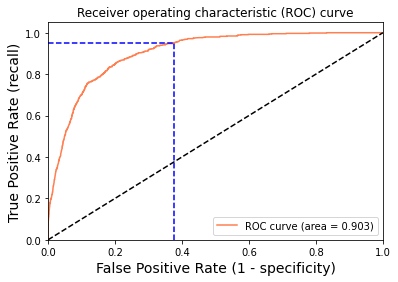

Using a threshold of 0.021 guarantees a sensitivity of 0.951 and a specificity of 0.624, i.e. a false positive rate of 37.58%.


In [27]:
# Print Out Accuracy
print('Training accuracy {:.4f}'.format(model.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(X_test,y_test)))

y_pred_proba = model.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)

idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

### Submit Predictions

In [30]:
# Predict and prepare for submitting
ids = pd.DataFrame(test['ID'])
test_df = test.drop(['ID'], axis=1)
predictions = pd.DataFrame(model.predict(test_df))
final = ids.join(predictions).rename(columns={0: 'TARGET'})
final.to_csv('submission.csv',header=["ID", "TARGET"], index=False)

#Submit a prediction to Kaggle
import os
os.system("kaggle competitions submit -c santander-customer-satisfaction -f submission.csv -m '{0}'".format(run_name))

# Retrieve Submissions and Show Last Result
submits = !kaggle competitions submissions -c santander-customer-satisfaction
time.sleep(10)
print("Last Submission Retrieved:")
parse_kaggle_submissions(submits)[:1]

Last Submission Retrieved:


,fileName,date,description,status,publicScore,privateScore
0,submission.csv,2021-11-27 23:00:56,Experiment_1_LGBMClassifier_with_metric_binary...,complete,0.50230,0.50207


### This chunk of code should be at the end of any experiment to be run
#### (We are storing all results to PostGres to be summarized later on)

In [31]:
# Create Dataframe retrieving all Runs
mlflow_runs = mlflow.search_runs('0')
mlflow_runs['duration'] = mlflow_runs.end_time - mlflow_runs.start_time # calculate run duration
mlflow_runs['duration'] = round(mlflow_runs.duration.astype('timedelta64[s]')/60,2) # Convert to minutes

#Get submission data
submits = !kaggle competitions submissions -c santander-customer-satisfaction
kaggle_runs = parse_kaggle_submissions(submits)

# Agregar nombre del Experimento
kaggle_runs = kaggle_runs.assign(Experiment=Experiment_Name)

# Correct Data Types
import numpy as np
kaggle_runs.publicScore = kaggle_runs.publicScore.replace('None',np.nan)  # Reemplazando None por NaN
kaggle_runs.publicScore = pd.to_numeric(kaggle_runs.publicScore)
kaggle_runs.privateScore = kaggle_runs.privateScore.replace('None',np.nan)  # Reemplazando None por NaN
kaggle_runs.privateScore = pd.to_numeric(kaggle_runs.privateScore)
kaggle_runs.date = pd.to_datetime(kaggle_runs.date)

# Create Connection to DataBase
from sqlalchemy import create_engine
user = "workshop"
password = "w0rkzh0p"
host = "postgres"
port = "5432"
database = "workshop"
schema = "workshop"
engine = create_engine(f"postgresql://{user}:{password}@{host}:{port}/{database}")
connection = engine.connect()

# UPSERT KAGGLE NEW RESULTS to PostGreSQL

if engine.dialect.has_table(connection, 'kaggle_runs'):   #check if table exists
    table = pd.read_sql_table('kaggle_runs', engine) 
    merged = pd.concat([kaggle_runs[~kaggle_runs.date.isin(table.date)], table])
    merged.to_sql('kaggle_runs', con=engine, if_exists='replace',method='multi', index=False)
else:
    kaggle_runs.to_sql('kaggle_runs', con=engine, if_exists='replace',method='multi', index=False)
    
# UPSERT MLFLOW RUNS to PostGreSQL

if engine.dialect.has_table(engine.connect(), 'mlflow_runs'):   #check if table exists
    table2 = pd.read_sql_table('mlflow_runs', engine) 
    merged2 = pd.concat([mlflow_runs[~mlflow_runs.run_id.isin(table2.run_id)], table2])
    merged2.to_sql('mlflow_runs', con=engine, if_exists='replace',method='multi', index=False)
else:
    mlflow_runs.to_sql('mlflow_runs', con=engine, if_exists='replace',method='multi', index=False)